In [113]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_validate,cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore')

In [78]:
%matplotlib inline

In [79]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# **2. Gathering and Observing Data**

In [80]:
df_ = pd.read_csv("../melbourne_house/Melbourne_housing_FULL.csv")
df = df_.copy()
df.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,68 Studley St,2,h,NaN,SS,Jellis,3/09/2016,2.500,3067.000,2.000,1.000,1.000,126.000,NaN,NaN,Yarra City Council,-37.801,144.996,Northern Metropolitan,4019.000
1,Abbotsford,85 Turner St,2,h,1480000.000,S,Biggin,3/12/2016,2.500,3067.000,2.000,1.000,1.000,202.000,NaN,NaN,Yarra City Council,-37.800,144.998,Northern Metropolitan,4019.000
2,Abbotsford,25 Bloomburg St,2,h,1035000.000,S,Biggin,4/02/2016,2.500,3067.000,2.000,1.000,0.000,156.000,79.000,1900.000,Yarra City Council,-37.808,144.993,Northern Metropolitan,4019.000
3,Abbotsford,18/659 Victoria St,3,u,NaN,VB,Rounds,4/02/2016,2.500,3067.000,3.000,2.000,1.000,0.000,NaN,NaN,Yarra City Council,-37.811,145.012,Northern Metropolitan,4019.000
4,Abbotsford,5 Charles St,3,h,1465000.000,SP,Biggin,4/03/2017,2.500,3067.000,3.000,2.000,0.000,134.000,150.000,1900.000,Yarra City Council,-37.809,144.994,Northern Metropolitan,4019.000


In [81]:
# Find the shape, number of columns and size of the dataset
print(f"Shape: {df.shape}")
print(f"Size: {df.size}")
print(f"Number of Columns: {len(df.columns)}")

Shape: (34857, 21)
Size: 731997
Number of Columns: 21


In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34857 entries, 0 to 34856
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         34857 non-null  object 
 1   Address        34857 non-null  object 
 2   Rooms          34857 non-null  int64  
 3   Type           34857 non-null  object 
 4   Price          27247 non-null  float64
 5   Method         34857 non-null  object 
 6   SellerG        34857 non-null  object 
 7   Date           34857 non-null  object 
 8   Distance       34856 non-null  float64
 9   Postcode       34856 non-null  float64
 10  Bedroom2       26640 non-null  float64
 11  Bathroom       26631 non-null  float64
 12  Car            26129 non-null  float64
 13  Landsize       23047 non-null  float64
 14  BuildingArea   13742 non-null  float64
 15  YearBuilt      15551 non-null  float64
 16  CouncilArea    34854 non-null  object 
 17  Lattitude      26881 non-null  float64
 18  Longti

In [83]:
df.isnull().sum()

Suburb               0
Address              0
Rooms                0
Type                 0
Price             7610
Method               0
SellerG              0
Date                 0
Distance             1
Postcode             1
Bedroom2          8217
Bathroom          8226
Car               8728
Landsize         11810
BuildingArea     21115
YearBuilt        19306
CouncilArea          3
Lattitude         7976
Longtitude        7976
Regionname           3
Propertycount        3
dtype: int64

In [84]:
df.drop_duplicates(inplace=True)

In [85]:
df.shape

(34856, 21)

In [86]:
round((df.describe().T), 2)

,count,mean,std,min,25%,50%,75%,max
Rooms,34856.000,3.030,0.970,1.000,2.000,3.000,4.000,16.000
Price,27247.000,1050173.340,641467.130,85000.000,635000.000,870000.000,1295000.000,11200000.000
Distance,34855.000,11.180,6.790,0.000,6.400,10.300,14.000,48.100
Postcode,34855.000,3116.060,109.030,3000.000,3051.000,3103.000,3156.000,3978.000
Bedroom2,26639.000,3.080,0.980,0.000,2.000,3.000,4.000,30.000
Bathroom,26630.000,1.620,0.720,0.000,1.000,2.000,2.000,12.000
Car,26128.000,1.730,1.010,0.000,1.000,2.000,2.000,26.000
Landsize,23046.000,593.610,3398.920,0.000,224.000,521.000,670.000,433014.000
BuildingArea,13741.000,160.250,401.280,0.000,102.000,136.000,188.000,44515.000
YearBuilt,15550.000,1965.290,37.330,1196.000,1940.000,1970.000,2000.000,2106.000


In [87]:
df.dropna(subset = ['Price'],inplace=True)
df.reset_index(drop=True,inplace=True)
df.shape

(27247, 21)

### **2.1 Object Columns To Category**


**The values of some variables are given as objects. At the same time, we observe
that there are also categorical values. This might give us trouble when examining the
dataset. Therefore, in such cases, we need to define the variables categorically.**

In [88]:
obj_cols = [col for col in df.select_dtypes(['object']).columns]
obj_cols

['Suburb',
 'Address',
 'Type',
 'Method',
 'SellerG',
 'Date',
 'CouncilArea',
 'Regionname']

In [89]:
for col in obj_cols:
    df[col] = df[col].astype('category')

In [90]:
print(df.select_dtypes(['category']).columns)

Index(['Suburb', 'Address', 'Type', 'Method', 'SellerG', 'Date', 'CouncilArea',
       'Regionname'],
      dtype='object')


In [94]:
cat_columns = [col for col in df.select_dtypes(['category']).columns]
num_columns = [col for col in df.select_dtypes(include=['int64', 'float64'])]

In [97]:
for column in cat_columns:
    df[column] = df[column].fillna(df[column].mode().iloc[0])
for column in num_columns:
    df[column] = df[column].fillna(df[column].median())
df.isna().sum()

Suburb           0
Address          0
Rooms            0
Type             0
Price            0
Method           0
SellerG          0
Date             0
Distance         0
Postcode         0
Bedroom2         0
Bathroom         0
Car              0
Landsize         0
BuildingArea     0
YearBuilt        0
CouncilArea      0
Lattitude        0
Longtitude       0
Regionname       0
Propertycount    0
dtype: int64

### **2.3 Outlier Detection With IQR**

In [91]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1=0.15, q3=0.85)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False
    
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1=0.15, q3=0.85)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [92]:
# Outliers in numerical columns like Landsize, BuildingArea will be detected and removed
numeric_columns = df.select_dtypes(include=["int64", "float64"]).columns
df["Landsize"].dtypes

dtype('float64')

In [98]:
def find_outliers(col):
    z=np.abs(stats.zscore(col))
    idx_outliers=np.where(z>3,True,False)
    return pd.Series(idx_outliers,index=col.index)
idx=find_outliers(df["Landsize"])
idx2=find_outliers(df["BuildingArea"])
idx3=find_outliers(df["YearBuilt"])
a=df.loc[idx]
b=df.loc[idx2]
c=df.loc[idx3]
d=pd.concat([a,b,c],join="inner")
df.drop(d.index, inplace = True)
df.reset_index(drop=True,inplace=True)
(round((df.describe().T),2))

,count,mean,std,min,25%,50%,75%,max
Rooms,26696.000,2.990,0.950,1.000,2.000,3.000,4.000,16.000
Price,26696.000,1037745.040,627554.060,85000.000,631000.000,861000.000,1276000.000,11200000.000
Distance,26696.000,11.390,6.740,0.000,6.600,10.500,14.000,48.100
Postcode,26696.000,3113.800,111.410,3000.000,3046.000,3088.000,3153.000,3978.000
Bedroom2,26696.000,3.040,0.830,0.000,3.000,3.000,3.000,20.000
Bathroom,26696.000,1.450,0.660,0.000,1.000,1.000,2.000,9.000
Car,26696.000,1.800,0.860,0.000,1.000,2.000,2.000,18.000
Landsize,26696.000,511.480,430.480,0.000,367.000,512.000,593.000,9338.000
BuildingArea,26696.000,139.760,53.430,0.000,133.000,133.000,133.000,958.000
YearBuilt,26696.000,1970.070,21.400,1895.000,1970.000,1970.000,1970.000,2019.000


In [99]:
le = LabelEncoder()
for column in cat_columns:
    df[column] = le.fit_transform(df[column])

<Axes: xlabel='Price', ylabel='Count'>

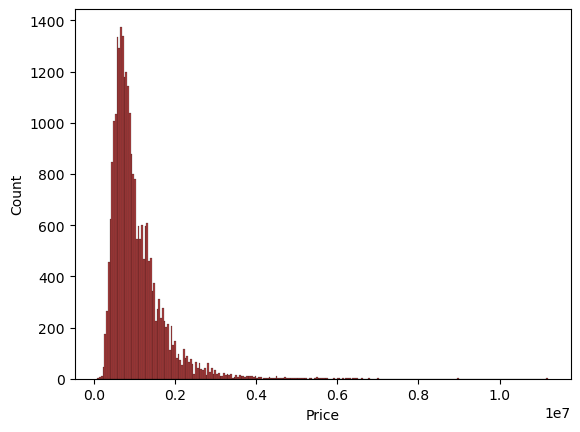

In [103]:
sns.histplot(df, x="Price",color="darkred")

In [106]:
X=df.drop(["Price","Address"],axis=1)
y=df["Price"]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)

In [110]:
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=30)

In [111]:
# Shape of training data
print("X_train shape: {}".format(X_train.shape))
# Shape of testing data
print("X_test shape: {}".format(X_test.shape))
# Shape of labels for training
print("y_train shape: {}".format(y_train.shape))
# Shape of labels for testing
print("y_test shape: {}".format(y_test.shape))

X_train shape: (20022, 19)
X_test shape: (6674, 19)
y_train shape: (20022,)
y_test shape: (6674,)


In [112]:
######################################################
#  Automated Hyperparameter Optimization
######################################################

rf_params = {"max_depth": [5, 8, 15, None],
             "max_features": [5, 7, "auto"],
             "min_samples_split": [8, 15, 20],
             "n_estimators": [200, 500]}

gbm_params = {"learning_rate": [0.01, 0.1],
              "max_depth": [3, 8],
              "n_estimators": [500, 1000],
              "subsample": [1, 0.5, 0.7]}


lightgbm_params = {"learning_rate": [0.01, 0.1],
                   "n_estimators": [300, 500],
                   "colsample_bytree": [0.7, 1]}

catboost_params = {"iterations": [200, 500],
                   "learning_rate": [0.01, 0.1],
                   "depth": [3, 6]}


regressors = [ ("RF", RandomForestRegressor(), rf_params),
               ("GBM", GradientBoostingRegressor(), gbm_params),
               ("LightGBM", LGBMRegressor(), lightgbm_params),
               ("CatBoost", CatBoostRegressor(), catboost_params)
             ]

In [114]:
best_models = {}

for name, regressor, params in regressors:
    print(f"########## {name} ##########")
    cv_results = cross_validate(regressor, 
                                X_train, y_train, 
                                cv=5, 
                                scoring=['neg_mean_squared_error', 'r2']
                               )
    rmse = np.mean(np.sqrt(-cv_results['test_neg_mean_squared_error']))   
    print(f"RMSE: {round(rmse, 4)} ({name}) ")
    
    r2 = cv_results["test_r2"].mean()
    print(f"R2 Score: {round(r2, 4)} ({name})")
    
    gs_best = GridSearchCV(regressor, param_grid=params,
                          cv=3, n_jobs=-1, verbose=False).fit(X_train, y_train)
    
    final_model = regressor.set_params(**gs_best.best_params_)
    cv_results = cross_validate(regressor, 
                                X_train, y_train, 
                                cv=5, 
                                scoring=['neg_mean_squared_error', 'r2']
                               )
    rmse = np.mean(np.sqrt(-cv_results['test_neg_mean_squared_error']))   
    print(f"RMSE (After): {round(rmse, 4)} ({name}) ")
    
    r2 = cv_results["test_r2"].mean()
    print(f"R2 Score (After): {round(r2, 4)} ({name})")
    
    best_models[name] = final_model

########## RF ##########
RMSE: 303676.3621 (RF) 
R2 Score: 0.7688 (RF)
RMSE (After): 292025.6941 (RF) 
R2 Score (After): 0.7862 (RF)
########## GBM ##########
RMSE: 325172.8781 (GBM) 
R2 Score: 0.7348 (GBM)
RMSE (After): 285469.9515 (GBM) 
R2 Score (After): 0.7957 (GBM)
########## LightGBM ##########
RMSE: 291974.2523 (LightGBM) 
R2 Score: 0.7863 (LightGBM)
RMSE (After): 283592.0891 (LightGBM) 
R2 Score (After): 0.7984 (LightGBM)
########## CatBoost ##########
Learning rate set to 0.06346
0:	learn: 610645.4201669	total: 154ms	remaining: 2m 33s
1:	learn: 590306.5266403	total: 157ms	remaining: 1m 18s
2:	learn: 571552.6285327	total: 160ms	remaining: 53.3s
3:	learn: 554362.8673001	total: 164ms	remaining: 40.8s
4:	learn: 538093.9952859	total: 167ms	remaining: 33.2s
5:	learn: 522998.1769276	total: 170ms	remaining: 28.1s
6:	learn: 510309.4648897	total: 173ms	remaining: 24.5s
7:	learn: 497334.4572635	total: 176ms	remaining: 21.8s
8:	learn: 486146.2982425	total: 179ms	remaining: 19.7s
9:	learn:

156:	learn: 296518.1550630	total: 579ms	remaining: 3.11s
157:	learn: 296153.6452574	total: 582ms	remaining: 3.1s
158:	learn: 295790.2998009	total: 585ms	remaining: 3.09s
159:	learn: 295500.0806053	total: 588ms	remaining: 3.08s
160:	learn: 295236.1197723	total: 591ms	remaining: 3.08s
161:	learn: 294965.1291615	total: 593ms	remaining: 3.07s
162:	learn: 294684.1110276	total: 596ms	remaining: 3.06s
163:	learn: 294496.1574075	total: 599ms	remaining: 3.05s
164:	learn: 294213.2341595	total: 601ms	remaining: 3.04s
165:	learn: 293989.5198230	total: 604ms	remaining: 3.04s
166:	learn: 293909.1694434	total: 607ms	remaining: 3.03s
167:	learn: 293599.8409129	total: 610ms	remaining: 3.02s
168:	learn: 293352.0638829	total: 612ms	remaining: 3.01s
169:	learn: 293156.3302732	total: 615ms	remaining: 3s
170:	learn: 293001.8993279	total: 617ms	remaining: 2.99s
171:	learn: 292533.6421279	total: 620ms	remaining: 2.98s
172:	learn: 292174.9256320	total: 623ms	remaining: 2.98s
173:	learn: 291950.7416885	total: 6

312:	learn: 265340.1169642	total: 978ms	remaining: 2.15s
313:	learn: 265236.4613969	total: 981ms	remaining: 2.14s
314:	learn: 265134.5823133	total: 984ms	remaining: 2.14s
315:	learn: 265006.8156713	total: 986ms	remaining: 2.13s
316:	learn: 264950.0059236	total: 989ms	remaining: 2.13s
317:	learn: 264820.2238795	total: 992ms	remaining: 2.13s
318:	learn: 264649.6035759	total: 994ms	remaining: 2.12s
319:	learn: 264475.5766452	total: 997ms	remaining: 2.12s
320:	learn: 264328.0273145	total: 1000ms	remaining: 2.11s
321:	learn: 264170.6623409	total: 1s	remaining: 2.11s
322:	learn: 264044.7981241	total: 1s	remaining: 2.11s
323:	learn: 263934.6649922	total: 1.01s	remaining: 2.1s
324:	learn: 263776.4476307	total: 1.01s	remaining: 2.1s
325:	learn: 263623.1455688	total: 1.01s	remaining: 2.09s
326:	learn: 263497.4957883	total: 1.01s	remaining: 2.09s
327:	learn: 263458.9428523	total: 1.02s	remaining: 2.08s
328:	learn: 263337.0323173	total: 1.02s	remaining: 2.08s
329:	learn: 263233.0756454	total: 1.02

460:	learn: 247767.0338846	total: 1.36s	remaining: 1.59s
461:	learn: 247691.1222594	total: 1.37s	remaining: 1.59s
462:	learn: 247638.3038968	total: 1.37s	remaining: 1.59s
463:	learn: 247530.1262686	total: 1.37s	remaining: 1.58s
464:	learn: 247438.7499544	total: 1.37s	remaining: 1.58s
465:	learn: 247363.1630013	total: 1.38s	remaining: 1.58s
466:	learn: 247305.2840318	total: 1.38s	remaining: 1.57s
467:	learn: 247202.3635864	total: 1.38s	remaining: 1.57s
468:	learn: 247146.1039990	total: 1.39s	remaining: 1.57s
469:	learn: 247029.7752286	total: 1.39s	remaining: 1.56s
470:	learn: 246917.6056732	total: 1.39s	remaining: 1.56s
471:	learn: 246819.4101587	total: 1.39s	remaining: 1.56s
472:	learn: 246668.1692006	total: 1.4s	remaining: 1.55s
473:	learn: 246660.3174376	total: 1.4s	remaining: 1.55s
474:	learn: 246443.4154171	total: 1.4s	remaining: 1.55s
475:	learn: 246369.6464130	total: 1.4s	remaining: 1.54s
476:	learn: 246282.9654996	total: 1.41s	remaining: 1.54s
477:	learn: 246147.7213782	total: 1

612:	learn: 234224.2393094	total: 1.76s	remaining: 1.11s
613:	learn: 234144.1199344	total: 1.77s	remaining: 1.11s
614:	learn: 234105.8122853	total: 1.77s	remaining: 1.11s
615:	learn: 234030.4174620	total: 1.77s	remaining: 1.1s
616:	learn: 233971.7877808	total: 1.77s	remaining: 1.1s
617:	learn: 233900.9145394	total: 1.78s	remaining: 1.1s
618:	learn: 233826.7958854	total: 1.78s	remaining: 1.09s
619:	learn: 233789.5337275	total: 1.78s	remaining: 1.09s
620:	learn: 233715.2500426	total: 1.78s	remaining: 1.09s
621:	learn: 233656.4982596	total: 1.79s	remaining: 1.09s
622:	learn: 233629.5658705	total: 1.79s	remaining: 1.08s
623:	learn: 233627.9349871	total: 1.79s	remaining: 1.08s
624:	learn: 233571.4708050	total: 1.79s	remaining: 1.08s
625:	learn: 233486.9105590	total: 1.8s	remaining: 1.07s
626:	learn: 233363.4915906	total: 1.8s	remaining: 1.07s
627:	learn: 233316.8977293	total: 1.8s	remaining: 1.07s
628:	learn: 233247.3033554	total: 1.8s	remaining: 1.06s
629:	learn: 233183.9053984	total: 1.81

768:	learn: 224286.5296501	total: 2.16s	remaining: 650ms
769:	learn: 224257.4184852	total: 2.17s	remaining: 647ms
770:	learn: 224206.5691780	total: 2.17s	remaining: 644ms
771:	learn: 224147.9638133	total: 2.17s	remaining: 641ms
772:	learn: 224141.1581818	total: 2.17s	remaining: 638ms
773:	learn: 224124.5024855	total: 2.17s	remaining: 635ms
774:	learn: 224014.0974162	total: 2.18s	remaining: 632ms
775:	learn: 223963.5467761	total: 2.18s	remaining: 629ms
776:	learn: 223903.1806753	total: 2.18s	remaining: 626ms
777:	learn: 223877.7310711	total: 2.19s	remaining: 624ms
778:	learn: 223825.4189142	total: 2.19s	remaining: 621ms
779:	learn: 223728.4611173	total: 2.19s	remaining: 618ms
780:	learn: 223686.7441882	total: 2.19s	remaining: 615ms
781:	learn: 223646.0789257	total: 2.19s	remaining: 612ms
782:	learn: 223588.5193336	total: 2.2s	remaining: 609ms
783:	learn: 223532.5588977	total: 2.2s	remaining: 606ms
784:	learn: 223485.3489976	total: 2.2s	remaining: 603ms
785:	learn: 223434.2136307	total: 

925:	learn: 215985.1887707	total: 2.56s	remaining: 205ms
926:	learn: 215963.1906995	total: 2.57s	remaining: 202ms
927:	learn: 215862.7381010	total: 2.57s	remaining: 199ms
928:	learn: 215803.3652268	total: 2.57s	remaining: 197ms
929:	learn: 215755.3231448	total: 2.58s	remaining: 194ms
930:	learn: 215728.6902433	total: 2.58s	remaining: 191ms
931:	learn: 215694.1573764	total: 2.58s	remaining: 188ms
932:	learn: 215570.2870152	total: 2.58s	remaining: 185ms
933:	learn: 215531.2610633	total: 2.58s	remaining: 183ms
934:	learn: 215482.3003419	total: 2.59s	remaining: 180ms
935:	learn: 215447.3185782	total: 2.59s	remaining: 177ms
936:	learn: 215394.8194696	total: 2.59s	remaining: 174ms
937:	learn: 215355.7915245	total: 2.6s	remaining: 172ms
938:	learn: 215300.0203545	total: 2.6s	remaining: 169ms
939:	learn: 215233.8496578	total: 2.6s	remaining: 166ms
940:	learn: 215186.3414120	total: 2.6s	remaining: 163ms
941:	learn: 215157.8956196	total: 2.61s	remaining: 160ms
942:	learn: 215107.8701244	total: 2

69:	learn: 323027.2714911	total: 202ms	remaining: 2.68s
70:	learn: 322639.6759860	total: 204ms	remaining: 2.67s
71:	learn: 322168.6081672	total: 207ms	remaining: 2.67s
72:	learn: 321719.7738830	total: 210ms	remaining: 2.66s
73:	learn: 321078.9211223	total: 213ms	remaining: 2.66s
74:	learn: 320642.2032950	total: 215ms	remaining: 2.65s
75:	learn: 320142.0841175	total: 218ms	remaining: 2.64s
76:	learn: 319704.3546404	total: 220ms	remaining: 2.64s
77:	learn: 319349.2255253	total: 223ms	remaining: 2.63s
78:	learn: 318951.7571519	total: 225ms	remaining: 2.63s
79:	learn: 318520.1724752	total: 228ms	remaining: 2.62s
80:	learn: 318132.1964479	total: 231ms	remaining: 2.62s
81:	learn: 317693.3981654	total: 233ms	remaining: 2.61s
82:	learn: 317499.1272205	total: 236ms	remaining: 2.6s
83:	learn: 317238.1024902	total: 238ms	remaining: 2.6s
84:	learn: 316834.8404492	total: 241ms	remaining: 2.59s
85:	learn: 316363.2103005	total: 243ms	remaining: 2.58s
86:	learn: 316068.4166944	total: 245ms	remaining: 

229:	learn: 277238.1037799	total: 598ms	remaining: 2s
230:	learn: 277053.7511424	total: 601ms	remaining: 2s
231:	learn: 276848.0520557	total: 603ms	remaining: 2s
232:	learn: 276649.0725634	total: 606ms	remaining: 1.99s
233:	learn: 276361.3147518	total: 609ms	remaining: 1.99s
234:	learn: 276111.4560550	total: 611ms	remaining: 1.99s
235:	learn: 275964.1967106	total: 614ms	remaining: 1.99s
236:	learn: 275758.3318430	total: 616ms	remaining: 1.98s
237:	learn: 275672.6661607	total: 619ms	remaining: 1.98s
238:	learn: 275413.3381038	total: 621ms	remaining: 1.98s
239:	learn: 275288.5872266	total: 624ms	remaining: 1.98s
240:	learn: 275113.3424369	total: 626ms	remaining: 1.97s
241:	learn: 275035.7231498	total: 629ms	remaining: 1.97s
242:	learn: 274828.6545332	total: 631ms	remaining: 1.97s
243:	learn: 274664.6348577	total: 634ms	remaining: 1.96s
244:	learn: 274393.7544008	total: 637ms	remaining: 1.96s
245:	learn: 274216.0988681	total: 639ms	remaining: 1.96s
246:	learn: 274015.3199065	total: 642ms	

387:	learn: 253743.3583308	total: 999ms	remaining: 1.57s
388:	learn: 253632.6534774	total: 1s	remaining: 1.57s
389:	learn: 253562.1825766	total: 1s	remaining: 1.57s
390:	learn: 253466.0759275	total: 1.01s	remaining: 1.57s
391:	learn: 253330.1351715	total: 1.01s	remaining: 1.56s
392:	learn: 253264.5302750	total: 1.01s	remaining: 1.56s
393:	learn: 253162.7931904	total: 1.01s	remaining: 1.56s
394:	learn: 253062.8518663	total: 1.02s	remaining: 1.56s
395:	learn: 252955.5974033	total: 1.02s	remaining: 1.55s
396:	learn: 252876.8399743	total: 1.02s	remaining: 1.55s
397:	learn: 252721.1444027	total: 1.02s	remaining: 1.55s
398:	learn: 252572.0521427	total: 1.03s	remaining: 1.55s
399:	learn: 252488.9733143	total: 1.03s	remaining: 1.54s
400:	learn: 252433.2693859	total: 1.03s	remaining: 1.54s
401:	learn: 252337.4110830	total: 1.03s	remaining: 1.54s
402:	learn: 252160.7075986	total: 1.04s	remaining: 1.54s
403:	learn: 252050.2376939	total: 1.04s	remaining: 1.53s
404:	learn: 251910.1373677	total: 1.0

604:	learn: 232547.3183097	total: 1.58s	remaining: 1.03s
605:	learn: 232446.8041431	total: 1.58s	remaining: 1.03s
606:	learn: 232399.7341204	total: 1.58s	remaining: 1.02s
607:	learn: 232314.0424457	total: 1.58s	remaining: 1.02s
608:	learn: 232253.4553187	total: 1.59s	remaining: 1.02s
609:	learn: 232179.7500639	total: 1.59s	remaining: 1.02s
610:	learn: 232123.9811246	total: 1.59s	remaining: 1.01s
611:	learn: 232016.8278180	total: 1.59s	remaining: 1.01s
612:	learn: 231954.1890746	total: 1.6s	remaining: 1.01s
613:	learn: 231815.8673173	total: 1.6s	remaining: 1.01s
614:	learn: 231738.2710301	total: 1.6s	remaining: 1s
615:	learn: 231648.3740690	total: 1.61s	remaining: 1s
616:	learn: 231553.8343169	total: 1.61s	remaining: 999ms
617:	learn: 231474.3196023	total: 1.61s	remaining: 996ms
618:	learn: 231344.7376509	total: 1.61s	remaining: 993ms
619:	learn: 231293.0565834	total: 1.62s	remaining: 991ms
620:	learn: 231238.8060305	total: 1.62s	remaining: 988ms
621:	learn: 231127.0926432	total: 1.62s	

758:	learn: 222014.4824601	total: 1.98s	remaining: 627ms
759:	learn: 221964.8173235	total: 1.98s	remaining: 625ms
760:	learn: 221869.7437621	total: 1.98s	remaining: 622ms
761:	learn: 221822.8870001	total: 1.98s	remaining: 620ms
762:	learn: 221749.8862334	total: 1.99s	remaining: 617ms
763:	learn: 221666.6693672	total: 1.99s	remaining: 615ms
764:	learn: 221607.9030598	total: 1.99s	remaining: 612ms
765:	learn: 221541.7239163	total: 2s	remaining: 610ms
766:	learn: 221489.4396018	total: 2s	remaining: 607ms
767:	learn: 221391.8892295	total: 2s	remaining: 604ms
768:	learn: 221350.8613839	total: 2s	remaining: 602ms
769:	learn: 221291.5822006	total: 2.01s	remaining: 599ms
770:	learn: 221237.1617350	total: 2.01s	remaining: 597ms
771:	learn: 221201.8298341	total: 2.01s	remaining: 594ms
772:	learn: 221168.4685037	total: 2.01s	remaining: 591ms
773:	learn: 221149.5626923	total: 2.02s	remaining: 589ms
774:	learn: 221097.2872842	total: 2.02s	remaining: 586ms
775:	learn: 221063.6850053	total: 2.02s	rem

916:	learn: 214455.8590873	total: 2.38s	remaining: 215ms
917:	learn: 214399.2278647	total: 2.38s	remaining: 213ms
918:	learn: 214347.2839093	total: 2.38s	remaining: 210ms
919:	learn: 214260.5981595	total: 2.39s	remaining: 207ms
920:	learn: 214146.0588855	total: 2.39s	remaining: 205ms
921:	learn: 214112.3230635	total: 2.39s	remaining: 202ms
922:	learn: 214028.6922175	total: 2.39s	remaining: 200ms
923:	learn: 213980.3185088	total: 2.4s	remaining: 197ms
924:	learn: 213904.8742142	total: 2.4s	remaining: 195ms
925:	learn: 213859.5520515	total: 2.4s	remaining: 192ms
926:	learn: 213825.9766158	total: 2.4s	remaining: 189ms
927:	learn: 213748.9964723	total: 2.41s	remaining: 187ms
928:	learn: 213602.9130932	total: 2.41s	remaining: 184ms
929:	learn: 213515.9139562	total: 2.41s	remaining: 182ms
930:	learn: 213469.1648689	total: 2.41s	remaining: 179ms
931:	learn: 213441.6225507	total: 2.42s	remaining: 176ms
932:	learn: 213423.4693281	total: 2.42s	remaining: 174ms
933:	learn: 213400.7336480	total: 2

66:	learn: 326443.3304959	total: 195ms	remaining: 2.71s
67:	learn: 325821.0772756	total: 198ms	remaining: 2.71s
68:	learn: 325183.7358106	total: 200ms	remaining: 2.7s
69:	learn: 324670.6977551	total: 203ms	remaining: 2.69s
70:	learn: 323987.6018402	total: 206ms	remaining: 2.69s
71:	learn: 323466.9565824	total: 208ms	remaining: 2.69s
72:	learn: 322862.2367106	total: 211ms	remaining: 2.68s
73:	learn: 322368.3563970	total: 214ms	remaining: 2.68s
74:	learn: 321932.9184073	total: 216ms	remaining: 2.67s
75:	learn: 321285.2248157	total: 219ms	remaining: 2.66s
76:	learn: 320687.1935454	total: 221ms	remaining: 2.65s
77:	learn: 320282.3850729	total: 224ms	remaining: 2.65s
78:	learn: 319832.4846047	total: 226ms	remaining: 2.64s
79:	learn: 319435.6713410	total: 229ms	remaining: 2.64s
80:	learn: 318690.3461913	total: 232ms	remaining: 2.63s
81:	learn: 318386.1895251	total: 235ms	remaining: 2.63s
82:	learn: 318049.3786544	total: 237ms	remaining: 2.62s
83:	learn: 317257.9122747	total: 240ms	remaining:

219:	learn: 278526.5884661	total: 591ms	remaining: 2.09s
220:	learn: 278179.1870817	total: 594ms	remaining: 2.09s
221:	learn: 278032.2098048	total: 596ms	remaining: 2.09s
222:	learn: 277880.1298499	total: 599ms	remaining: 2.09s
223:	learn: 277654.2971238	total: 602ms	remaining: 2.08s
224:	learn: 277530.6737585	total: 604ms	remaining: 2.08s
225:	learn: 277297.2527693	total: 607ms	remaining: 2.08s
226:	learn: 277199.2324385	total: 609ms	remaining: 2.07s
227:	learn: 276888.8465042	total: 611ms	remaining: 2.07s
228:	learn: 276697.6851516	total: 614ms	remaining: 2.07s
229:	learn: 276501.4921500	total: 617ms	remaining: 2.06s
230:	learn: 276242.0901282	total: 619ms	remaining: 2.06s
231:	learn: 275975.2639754	total: 622ms	remaining: 2.06s
232:	learn: 275786.0308420	total: 624ms	remaining: 2.06s
233:	learn: 275582.9871904	total: 627ms	remaining: 2.05s
234:	learn: 275480.3029878	total: 629ms	remaining: 2.05s
235:	learn: 275336.6963125	total: 632ms	remaining: 2.04s
236:	learn: 275197.1796062	tota

374:	learn: 254516.8980976	total: 986ms	remaining: 1.64s
375:	learn: 254343.7669167	total: 989ms	remaining: 1.64s
376:	learn: 254233.0432385	total: 992ms	remaining: 1.64s
377:	learn: 254094.8182142	total: 995ms	remaining: 1.64s
378:	learn: 253967.1685201	total: 997ms	remaining: 1.63s
379:	learn: 253878.9748369	total: 1s	remaining: 1.63s
380:	learn: 253744.9121504	total: 1s	remaining: 1.63s
381:	learn: 253619.8866210	total: 1s	remaining: 1.63s
382:	learn: 253504.0332353	total: 1.01s	remaining: 1.62s
383:	learn: 253334.4049601	total: 1.01s	remaining: 1.62s
384:	learn: 253279.7803658	total: 1.01s	remaining: 1.62s
385:	learn: 253157.0656801	total: 1.02s	remaining: 1.62s
386:	learn: 253054.0374802	total: 1.02s	remaining: 1.61s
387:	learn: 252962.3312201	total: 1.02s	remaining: 1.61s
388:	learn: 252872.4263474	total: 1.02s	remaining: 1.61s
389:	learn: 252746.3004614	total: 1.03s	remaining: 1.6s
390:	learn: 252670.5596207	total: 1.03s	remaining: 1.6s
391:	learn: 252512.1065347	total: 1.03s	re

529:	learn: 239576.7335061	total: 1.38s	remaining: 1.23s
530:	learn: 239466.2387473	total: 1.39s	remaining: 1.23s
531:	learn: 239412.5394471	total: 1.39s	remaining: 1.22s
532:	learn: 239295.1517174	total: 1.39s	remaining: 1.22s
533:	learn: 239217.4924902	total: 1.4s	remaining: 1.22s
534:	learn: 239162.2023253	total: 1.4s	remaining: 1.21s
535:	learn: 239096.3946548	total: 1.4s	remaining: 1.21s
536:	learn: 238931.9058794	total: 1.4s	remaining: 1.21s
537:	learn: 238805.0160491	total: 1.41s	remaining: 1.21s
538:	learn: 238723.4014382	total: 1.41s	remaining: 1.2s
539:	learn: 238506.4137455	total: 1.41s	remaining: 1.2s
540:	learn: 238456.0394453	total: 1.41s	remaining: 1.2s
541:	learn: 238352.7614321	total: 1.42s	remaining: 1.2s
542:	learn: 238207.0609130	total: 1.42s	remaining: 1.19s
543:	learn: 238134.6200833	total: 1.42s	remaining: 1.19s
544:	learn: 238095.4798851	total: 1.42s	remaining: 1.19s
545:	learn: 238091.4240116	total: 1.43s	remaining: 1.18s
546:	learn: 238002.3503917	total: 1.43s

683:	learn: 228002.4347831	total: 1.78s	remaining: 822ms
684:	learn: 227900.8461362	total: 1.78s	remaining: 820ms
685:	learn: 227819.9666808	total: 1.78s	remaining: 817ms
686:	learn: 227756.1202538	total: 1.79s	remaining: 814ms
687:	learn: 227731.9317965	total: 1.79s	remaining: 812ms
688:	learn: 227674.2009721	total: 1.79s	remaining: 809ms
689:	learn: 227611.1570376	total: 1.8s	remaining: 807ms
690:	learn: 227526.7344754	total: 1.8s	remaining: 804ms
691:	learn: 227413.5970308	total: 1.8s	remaining: 802ms
692:	learn: 227294.5558896	total: 1.8s	remaining: 799ms
693:	learn: 227293.5733308	total: 1.8s	remaining: 796ms
694:	learn: 227223.4729935	total: 1.81s	remaining: 794ms
695:	learn: 227133.0714869	total: 1.81s	remaining: 791ms
696:	learn: 227055.4158205	total: 1.81s	remaining: 788ms
697:	learn: 226971.9182597	total: 1.82s	remaining: 786ms
698:	learn: 226864.7821405	total: 1.82s	remaining: 783ms
699:	learn: 226813.9114925	total: 1.82s	remaining: 781ms
700:	learn: 226746.7388492	total: 1.

898:	learn: 215436.6044927	total: 2.37s	remaining: 266ms
899:	learn: 215411.3086985	total: 2.37s	remaining: 264ms
900:	learn: 215350.2681659	total: 2.38s	remaining: 261ms
901:	learn: 215282.5092445	total: 2.38s	remaining: 259ms
902:	learn: 215221.3094838	total: 2.38s	remaining: 256ms
903:	learn: 215087.6688146	total: 2.38s	remaining: 253ms
904:	learn: 215061.2415143	total: 2.39s	remaining: 251ms
905:	learn: 214995.7351695	total: 2.39s	remaining: 248ms
906:	learn: 214977.0524382	total: 2.39s	remaining: 245ms
907:	learn: 214956.0336605	total: 2.4s	remaining: 243ms
908:	learn: 214917.2681186	total: 2.4s	remaining: 240ms
909:	learn: 214852.9664501	total: 2.4s	remaining: 237ms
910:	learn: 214773.5212271	total: 2.4s	remaining: 235ms
911:	learn: 214674.1262066	total: 2.41s	remaining: 232ms
912:	learn: 214611.4443609	total: 2.41s	remaining: 230ms
913:	learn: 214581.8732916	total: 2.41s	remaining: 227ms
914:	learn: 214553.9119830	total: 2.41s	remaining: 224ms
915:	learn: 214516.4622350	total: 2

70:	learn: 321095.5133164	total: 196ms	remaining: 2.56s
71:	learn: 320272.1462964	total: 199ms	remaining: 2.56s
72:	learn: 319837.8718465	total: 201ms	remaining: 2.55s
73:	learn: 319398.9640862	total: 204ms	remaining: 2.55s
74:	learn: 318827.0179671	total: 207ms	remaining: 2.55s
75:	learn: 318352.8257820	total: 209ms	remaining: 2.54s
76:	learn: 317979.5555983	total: 215ms	remaining: 2.58s
77:	learn: 317492.5578322	total: 219ms	remaining: 2.58s
78:	learn: 317021.2977976	total: 222ms	remaining: 2.58s
79:	learn: 316657.9406345	total: 225ms	remaining: 2.58s
80:	learn: 315952.3680617	total: 227ms	remaining: 2.58s
81:	learn: 315640.7578991	total: 230ms	remaining: 2.57s
82:	learn: 315326.4019873	total: 232ms	remaining: 2.57s
83:	learn: 314737.0351846	total: 235ms	remaining: 2.56s
84:	learn: 314440.0581560	total: 237ms	remaining: 2.55s
85:	learn: 313900.5621705	total: 240ms	remaining: 2.54s
86:	learn: 313664.5954243	total: 242ms	remaining: 2.54s
87:	learn: 313385.4804974	total: 245ms	remaining

224:	learn: 278319.8913673	total: 591ms	remaining: 2.03s
225:	learn: 278289.7229815	total: 593ms	remaining: 2.03s
226:	learn: 278134.8331310	total: 595ms	remaining: 2.03s
227:	learn: 278111.8816990	total: 597ms	remaining: 2.02s
228:	learn: 277922.3831272	total: 600ms	remaining: 2.02s
229:	learn: 277660.6489266	total: 603ms	remaining: 2.02s
230:	learn: 277519.4634277	total: 605ms	remaining: 2.02s
231:	learn: 277312.2970143	total: 608ms	remaining: 2.01s
232:	learn: 277214.6117316	total: 611ms	remaining: 2.01s
233:	learn: 276920.0258620	total: 613ms	remaining: 2.01s
234:	learn: 276690.3041165	total: 616ms	remaining: 2s
235:	learn: 276533.5624988	total: 618ms	remaining: 2s
236:	learn: 276346.5240840	total: 621ms	remaining: 2s
237:	learn: 276106.8660480	total: 624ms	remaining: 2s
238:	learn: 275955.0294240	total: 626ms	remaining: 1.99s
239:	learn: 275793.8888000	total: 629ms	remaining: 1.99s
240:	learn: 275674.5708849	total: 632ms	remaining: 1.99s
241:	learn: 275447.3552642	total: 634ms	rem

379:	learn: 255855.5316604	total: 985ms	remaining: 1.61s
380:	learn: 255765.7777698	total: 988ms	remaining: 1.6s
381:	learn: 255607.6638279	total: 991ms	remaining: 1.6s
382:	learn: 255481.2634538	total: 994ms	remaining: 1.6s
383:	learn: 255210.7319272	total: 997ms	remaining: 1.6s
384:	learn: 255063.9021200	total: 1000ms	remaining: 1.6s
385:	learn: 254947.9173403	total: 1s	remaining: 1.59s
386:	learn: 254826.2554822	total: 1s	remaining: 1.59s
387:	learn: 254670.1148521	total: 1.01s	remaining: 1.59s
388:	learn: 254502.9058971	total: 1.01s	remaining: 1.59s
389:	learn: 254373.7749491	total: 1.01s	remaining: 1.58s
390:	learn: 254210.5562144	total: 1.01s	remaining: 1.58s
391:	learn: 254060.0067437	total: 1.02s	remaining: 1.58s
392:	learn: 253990.3057256	total: 1.02s	remaining: 1.58s
393:	learn: 253871.9558924	total: 1.02s	remaining: 1.57s
394:	learn: 253737.6276924	total: 1.02s	remaining: 1.57s
395:	learn: 253599.7557832	total: 1.03s	remaining: 1.57s
396:	learn: 253459.3953883	total: 1.03s	r

532:	learn: 239303.6606482	total: 1.38s	remaining: 1.21s
533:	learn: 239192.6861832	total: 1.39s	remaining: 1.21s
534:	learn: 239110.4916248	total: 1.39s	remaining: 1.21s
535:	learn: 239029.5894991	total: 1.39s	remaining: 1.2s
536:	learn: 238972.3373103	total: 1.39s	remaining: 1.2s
537:	learn: 238909.7328714	total: 1.4s	remaining: 1.2s
538:	learn: 238788.8247632	total: 1.4s	remaining: 1.2s
539:	learn: 238691.8805972	total: 1.4s	remaining: 1.19s
540:	learn: 238675.7961595	total: 1.4s	remaining: 1.19s
541:	learn: 238599.5544921	total: 1.41s	remaining: 1.19s
542:	learn: 238506.2290626	total: 1.41s	remaining: 1.19s
543:	learn: 238446.8486073	total: 1.41s	remaining: 1.18s
544:	learn: 238374.1567561	total: 1.41s	remaining: 1.18s
545:	learn: 238262.4931619	total: 1.42s	remaining: 1.18s
546:	learn: 238203.9708111	total: 1.42s	remaining: 1.18s
547:	learn: 238134.1577463	total: 1.42s	remaining: 1.17s
548:	learn: 238046.8345809	total: 1.43s	remaining: 1.17s
549:	learn: 238006.8323496	total: 1.43s

683:	learn: 228016.3214893	total: 1.78s	remaining: 822ms
684:	learn: 227964.0064495	total: 1.78s	remaining: 819ms
685:	learn: 227906.9039273	total: 1.78s	remaining: 817ms
686:	learn: 227844.9574478	total: 1.79s	remaining: 814ms
687:	learn: 227766.7599855	total: 1.79s	remaining: 812ms
688:	learn: 227705.7322435	total: 1.79s	remaining: 809ms
689:	learn: 227639.0847815	total: 1.79s	remaining: 807ms
690:	learn: 227565.5037099	total: 1.8s	remaining: 804ms
691:	learn: 227294.2626174	total: 1.8s	remaining: 801ms
692:	learn: 227134.6129130	total: 1.8s	remaining: 799ms
693:	learn: 227123.5035138	total: 1.8s	remaining: 796ms
694:	learn: 227112.8794064	total: 1.81s	remaining: 793ms
695:	learn: 227055.2368961	total: 1.81s	remaining: 791ms
696:	learn: 226999.1565333	total: 1.81s	remaining: 788ms
697:	learn: 226933.4387053	total: 1.81s	remaining: 786ms
698:	learn: 226863.9854856	total: 1.82s	remaining: 783ms
699:	learn: 226854.0228189	total: 1.82s	remaining: 780ms
700:	learn: 226774.2584319	total: 1

839:	learn: 218012.0037716	total: 2.18s	remaining: 415ms
840:	learn: 217960.8801833	total: 2.18s	remaining: 412ms
841:	learn: 217909.2534786	total: 2.18s	remaining: 410ms
842:	learn: 217901.4932112	total: 2.19s	remaining: 407ms
843:	learn: 217806.9921069	total: 2.19s	remaining: 404ms
844:	learn: 217764.4271360	total: 2.19s	remaining: 402ms
845:	learn: 217742.8604661	total: 2.19s	remaining: 399ms
846:	learn: 217576.0720364	total: 2.19s	remaining: 397ms
847:	learn: 217542.9837431	total: 2.2s	remaining: 394ms
848:	learn: 217470.1456562	total: 2.2s	remaining: 391ms
849:	learn: 217428.7796771	total: 2.2s	remaining: 389ms
850:	learn: 217346.1946887	total: 2.21s	remaining: 386ms
851:	learn: 217344.6800001	total: 2.21s	remaining: 384ms
852:	learn: 217303.0222430	total: 2.21s	remaining: 381ms
853:	learn: 217244.0181836	total: 2.21s	remaining: 379ms
854:	learn: 217185.6666179	total: 2.22s	remaining: 376ms
855:	learn: 217016.9820496	total: 2.22s	remaining: 373ms
856:	learn: 216939.8168912	total: 

992:	learn: 209651.1146024	total: 2.57s	remaining: 18.1ms
993:	learn: 209589.1014222	total: 2.58s	remaining: 15.6ms
994:	learn: 209526.1960032	total: 2.58s	remaining: 13ms
995:	learn: 209399.6300137	total: 2.58s	remaining: 10.4ms
996:	learn: 209357.1658217	total: 2.59s	remaining: 7.78ms
997:	learn: 209331.2471823	total: 2.59s	remaining: 5.19ms
998:	learn: 209284.2375882	total: 2.59s	remaining: 2.59ms
999:	learn: 209248.2151406	total: 2.59s	remaining: 0us
Learning rate set to 0.063461
0:	learn: 615170.6563662	total: 3.38ms	remaining: 3.38s
1:	learn: 595121.3272543	total: 6.46ms	remaining: 3.22s
2:	learn: 576728.9225181	total: 9.51ms	remaining: 3.16s
3:	learn: 559199.2412590	total: 13.2ms	remaining: 3.29s
4:	learn: 543229.1464102	total: 16.3ms	remaining: 3.25s
5:	learn: 528324.0496173	total: 19.8ms	remaining: 3.28s
6:	learn: 515162.9043020	total: 23ms	remaining: 3.26s
7:	learn: 502418.8231141	total: 26.1ms	remaining: 3.24s
8:	learn: 491942.0178378	total: 28.8ms	remaining: 3.17s
9:	learn:

150:	learn: 304223.7971248	total: 406ms	remaining: 2.28s
151:	learn: 304118.0200931	total: 408ms	remaining: 2.28s
152:	learn: 303683.7187607	total: 411ms	remaining: 2.28s
153:	learn: 303449.5929358	total: 414ms	remaining: 2.27s
154:	learn: 302920.2166237	total: 416ms	remaining: 2.27s
155:	learn: 302470.1318486	total: 419ms	remaining: 2.27s
156:	learn: 302258.8586705	total: 422ms	remaining: 2.26s
157:	learn: 302031.0910102	total: 425ms	remaining: 2.26s
158:	learn: 301861.2121442	total: 427ms	remaining: 2.26s
159:	learn: 301563.0045175	total: 430ms	remaining: 2.26s
160:	learn: 301250.9897922	total: 432ms	remaining: 2.25s
161:	learn: 300819.9597727	total: 435ms	remaining: 2.25s
162:	learn: 300464.7742236	total: 438ms	remaining: 2.25s
163:	learn: 300326.5473248	total: 440ms	remaining: 2.24s
164:	learn: 300062.2821734	total: 443ms	remaining: 2.24s
165:	learn: 299907.0331657	total: 445ms	remaining: 2.24s
166:	learn: 299896.7381338	total: 447ms	remaining: 2.23s
167:	learn: 299721.2131208	tota

305:	learn: 270595.3990806	total: 806ms	remaining: 1.83s
306:	learn: 270456.6130701	total: 808ms	remaining: 1.82s
307:	learn: 270258.0032010	total: 811ms	remaining: 1.82s
308:	learn: 270230.6863595	total: 814ms	remaining: 1.82s
309:	learn: 270132.0019001	total: 816ms	remaining: 1.82s
310:	learn: 269844.8242615	total: 819ms	remaining: 1.81s
311:	learn: 269705.9525339	total: 821ms	remaining: 1.81s
312:	learn: 269517.5271785	total: 824ms	remaining: 1.81s
313:	learn: 269265.8619071	total: 827ms	remaining: 1.8s
314:	learn: 269089.3088602	total: 829ms	remaining: 1.8s
315:	learn: 268896.6620311	total: 832ms	remaining: 1.8s
316:	learn: 268693.8583461	total: 835ms	remaining: 1.8s
317:	learn: 268299.2883054	total: 837ms	remaining: 1.79s
318:	learn: 268166.9323870	total: 840ms	remaining: 1.79s
319:	learn: 268037.3983203	total: 842ms	remaining: 1.79s
320:	learn: 267883.0775480	total: 845ms	remaining: 1.79s
321:	learn: 267740.0946326	total: 848ms	remaining: 1.78s
322:	learn: 267651.5432189	total: 8

463:	learn: 249388.5567572	total: 1.21s	remaining: 1.39s
464:	learn: 249290.7677868	total: 1.21s	remaining: 1.39s
465:	learn: 249175.7431078	total: 1.21s	remaining: 1.39s
466:	learn: 249070.2779032	total: 1.22s	remaining: 1.39s
467:	learn: 248985.4806865	total: 1.22s	remaining: 1.38s
468:	learn: 248928.7815275	total: 1.22s	remaining: 1.38s
469:	learn: 248831.0108331	total: 1.22s	remaining: 1.38s
470:	learn: 248727.9497040	total: 1.23s	remaining: 1.38s
471:	learn: 248564.3077811	total: 1.23s	remaining: 1.37s
472:	learn: 248483.9181809	total: 1.23s	remaining: 1.37s
473:	learn: 248396.9157473	total: 1.23s	remaining: 1.37s
474:	learn: 248348.6028811	total: 1.24s	remaining: 1.36s
475:	learn: 248239.4086282	total: 1.24s	remaining: 1.36s
476:	learn: 248164.7235623	total: 1.24s	remaining: 1.36s
477:	learn: 248009.7908441	total: 1.24s	remaining: 1.36s
478:	learn: 247844.6778630	total: 1.25s	remaining: 1.35s
479:	learn: 247812.2480156	total: 1.25s	remaining: 1.35s
480:	learn: 247782.5965339	tota

618:	learn: 236212.0510143	total: 1.6s	remaining: 985ms
619:	learn: 236144.5421803	total: 1.6s	remaining: 982ms
620:	learn: 236082.9855956	total: 1.6s	remaining: 980ms
621:	learn: 235938.0108779	total: 1.61s	remaining: 977ms
622:	learn: 235930.8964499	total: 1.61s	remaining: 975ms
623:	learn: 235842.8923351	total: 1.61s	remaining: 972ms
624:	learn: 235752.4708058	total: 1.62s	remaining: 970ms
625:	learn: 235683.7065456	total: 1.62s	remaining: 967ms
626:	learn: 235663.3653347	total: 1.62s	remaining: 965ms
627:	learn: 235565.9482234	total: 1.62s	remaining: 962ms
628:	learn: 235478.3842879	total: 1.63s	remaining: 960ms
629:	learn: 235446.6326541	total: 1.63s	remaining: 957ms
630:	learn: 235396.8824931	total: 1.63s	remaining: 954ms
631:	learn: 235307.2083293	total: 1.63s	remaining: 952ms
632:	learn: 235287.8093834	total: 1.64s	remaining: 949ms
633:	learn: 235202.4210156	total: 1.64s	remaining: 947ms
634:	learn: 235197.7696467	total: 1.64s	remaining: 944ms
635:	learn: 235097.5755421	total: 

771:	learn: 226184.2678299	total: 2s	remaining: 589ms
772:	learn: 226115.4203397	total: 2s	remaining: 587ms
773:	learn: 226004.5200652	total: 2s	remaining: 584ms
774:	learn: 225921.8067852	total: 2s	remaining: 582ms
775:	learn: 225861.9360043	total: 2.01s	remaining: 579ms
776:	learn: 225800.1043899	total: 2.01s	remaining: 577ms
777:	learn: 225750.2199586	total: 2.01s	remaining: 574ms
778:	learn: 225686.6487415	total: 2.01s	remaining: 572ms
779:	learn: 225603.5005295	total: 2.02s	remaining: 569ms
780:	learn: 225538.3113933	total: 2.02s	remaining: 566ms
781:	learn: 225449.4480095	total: 2.02s	remaining: 564ms
782:	learn: 225369.6667438	total: 2.02s	remaining: 561ms
783:	learn: 225331.0513521	total: 2.03s	remaining: 559ms
784:	learn: 225288.5804550	total: 2.03s	remaining: 556ms
785:	learn: 225199.0725709	total: 2.03s	remaining: 553ms
786:	learn: 225061.5785477	total: 2.04s	remaining: 551ms
787:	learn: 224989.7148445	total: 2.04s	remaining: 548ms
788:	learn: 224912.7547206	total: 2.04s	rem

926:	learn: 216585.3767529	total: 2.4s	remaining: 189ms
927:	learn: 216573.7301187	total: 2.4s	remaining: 186ms
928:	learn: 216476.8673904	total: 2.4s	remaining: 183ms
929:	learn: 216424.4324235	total: 2.4s	remaining: 181ms
930:	learn: 216379.2862160	total: 2.4s	remaining: 178ms
931:	learn: 216343.6341966	total: 2.41s	remaining: 176ms
932:	learn: 216283.2273845	total: 2.41s	remaining: 173ms
933:	learn: 216235.3514575	total: 2.41s	remaining: 171ms
934:	learn: 216181.1873035	total: 2.42s	remaining: 168ms
935:	learn: 216155.5692216	total: 2.42s	remaining: 165ms
936:	learn: 216100.9154756	total: 2.42s	remaining: 163ms
937:	learn: 216039.9021195	total: 2.42s	remaining: 160ms
938:	learn: 215998.7856705	total: 2.43s	remaining: 158ms
939:	learn: 215961.0307032	total: 2.43s	remaining: 155ms
940:	learn: 215910.7915967	total: 2.43s	remaining: 152ms
941:	learn: 215846.1080872	total: 2.43s	remaining: 150ms
942:	learn: 215797.5662676	total: 2.44s	remaining: 147ms
943:	learn: 215750.7163833	total: 2.

70:	learn: 310556.2041898	total: 212ms	remaining: 1.28s
71:	learn: 310021.5360259	total: 215ms	remaining: 1.28s
72:	learn: 309641.8003312	total: 218ms	remaining: 1.28s
73:	learn: 309114.6693551	total: 221ms	remaining: 1.27s
74:	learn: 308731.0613785	total: 224ms	remaining: 1.27s
75:	learn: 308583.4660831	total: 227ms	remaining: 1.27s
76:	learn: 308024.1458934	total: 230ms	remaining: 1.26s
77:	learn: 307313.1097936	total: 233ms	remaining: 1.26s
78:	learn: 307044.7910264	total: 235ms	remaining: 1.25s
79:	learn: 306482.2803033	total: 238ms	remaining: 1.25s
80:	learn: 306199.4829354	total: 241ms	remaining: 1.25s
81:	learn: 305902.5828737	total: 244ms	remaining: 1.24s
82:	learn: 305708.5175526	total: 246ms	remaining: 1.24s
83:	learn: 304752.5565091	total: 249ms	remaining: 1.23s
84:	learn: 304490.8515152	total: 252ms	remaining: 1.23s
85:	learn: 303991.7336399	total: 254ms	remaining: 1.22s
86:	learn: 303758.5156978	total: 257ms	remaining: 1.22s
87:	learn: 303530.1266585	total: 260ms	remaining

281:	learn: 252794.6199150	total: 793ms	remaining: 613ms
282:	learn: 252653.8270885	total: 796ms	remaining: 610ms
283:	learn: 252487.9650878	total: 799ms	remaining: 608ms
284:	learn: 252366.2783759	total: 802ms	remaining: 605ms
285:	learn: 252192.6960869	total: 806ms	remaining: 603ms
286:	learn: 252013.5552898	total: 809ms	remaining: 600ms
287:	learn: 251856.7543123	total: 812ms	remaining: 597ms
288:	learn: 251615.5718288	total: 814ms	remaining: 595ms
289:	learn: 251503.9757773	total: 817ms	remaining: 592ms
290:	learn: 251100.9505508	total: 820ms	remaining: 589ms
291:	learn: 251019.3519357	total: 823ms	remaining: 586ms
292:	learn: 250887.2912665	total: 825ms	remaining: 583ms
293:	learn: 250751.0257904	total: 828ms	remaining: 580ms
294:	learn: 250628.8459149	total: 831ms	remaining: 577ms
295:	learn: 250534.8334570	total: 833ms	remaining: 574ms
296:	learn: 250350.9824171	total: 836ms	remaining: 571ms
297:	learn: 250254.2990336	total: 839ms	remaining: 569ms
298:	learn: 250180.0329097	tota

493:	learn: 228023.2748737	total: 1.39s	remaining: 16.9ms
494:	learn: 227974.1033960	total: 1.39s	remaining: 14.1ms
495:	learn: 227847.5354924	total: 1.4s	remaining: 11.3ms
496:	learn: 227760.5339968	total: 1.4s	remaining: 8.45ms
497:	learn: 227723.7714603	total: 1.4s	remaining: 5.63ms
498:	learn: 227650.3256788	total: 1.41s	remaining: 2.82ms
499:	learn: 227568.5403740	total: 1.41s	remaining: 0us
0:	learn: 598360.7142886	total: 3.68ms	remaining: 1.83s
1:	learn: 568240.6969072	total: 7.36ms	remaining: 1.83s
2:	learn: 541771.7418665	total: 10.4ms	remaining: 1.72s
3:	learn: 517890.8984220	total: 13.9ms	remaining: 1.72s
4:	learn: 496460.0790270	total: 16.9ms	remaining: 1.68s
5:	learn: 479086.7611348	total: 20.1ms	remaining: 1.66s
6:	learn: 463757.0726662	total: 23.1ms	remaining: 1.63s
7:	learn: 448641.0709730	total: 26.3ms	remaining: 1.62s
8:	learn: 436370.0956978	total: 29.6ms	remaining: 1.61s
9:	learn: 427532.5060695	total: 32.8ms	remaining: 1.61s
10:	learn: 417306.6577020	total: 36.1ms	

150:	learn: 278426.6936495	total: 405ms	remaining: 937ms
151:	learn: 278089.4031894	total: 409ms	remaining: 935ms
152:	learn: 277741.8329542	total: 411ms	remaining: 932ms
153:	learn: 277506.3247462	total: 414ms	remaining: 930ms
154:	learn: 277248.4959107	total: 417ms	remaining: 928ms
155:	learn: 277032.3904103	total: 419ms	remaining: 924ms
156:	learn: 276528.4826366	total: 422ms	remaining: 923ms
157:	learn: 276196.7267461	total: 425ms	remaining: 920ms
158:	learn: 275981.4963991	total: 428ms	remaining: 918ms
159:	learn: 275675.2327859	total: 430ms	remaining: 915ms
160:	learn: 275418.9505746	total: 433ms	remaining: 912ms
161:	learn: 275082.5227877	total: 436ms	remaining: 909ms
162:	learn: 274777.9166211	total: 438ms	remaining: 906ms
163:	learn: 274420.4207788	total: 441ms	remaining: 904ms
164:	learn: 274214.7270203	total: 444ms	remaining: 901ms
165:	learn: 273984.6743709	total: 446ms	remaining: 897ms
166:	learn: 273572.2241406	total: 449ms	remaining: 895ms
167:	learn: 273387.0607878	tota

299:	learn: 246799.7742331	total: 799ms	remaining: 533ms
300:	learn: 246580.8657870	total: 802ms	remaining: 531ms
301:	learn: 246441.5797990	total: 805ms	remaining: 528ms
302:	learn: 246294.1699621	total: 807ms	remaining: 525ms
303:	learn: 246222.8861174	total: 810ms	remaining: 522ms
304:	learn: 246181.6666956	total: 812ms	remaining: 519ms
305:	learn: 246001.0944339	total: 815ms	remaining: 517ms
306:	learn: 245939.7204967	total: 818ms	remaining: 514ms
307:	learn: 245906.0074755	total: 820ms	remaining: 511ms
308:	learn: 245785.7479239	total: 823ms	remaining: 509ms
309:	learn: 245476.5601706	total: 825ms	remaining: 506ms
310:	learn: 245205.3902401	total: 828ms	remaining: 503ms
311:	learn: 244834.1492735	total: 831ms	remaining: 501ms
312:	learn: 244661.2707651	total: 833ms	remaining: 498ms
313:	learn: 244596.5710827	total: 836ms	remaining: 495ms
314:	learn: 244445.0944583	total: 839ms	remaining: 492ms
315:	learn: 244344.7145596	total: 841ms	remaining: 490ms
316:	learn: 244263.1485366	tota

452:	learn: 227345.2187837	total: 1.2s	remaining: 124ms
453:	learn: 227282.5142191	total: 1.2s	remaining: 122ms
454:	learn: 227123.7160318	total: 1.21s	remaining: 119ms
455:	learn: 227048.1527118	total: 1.21s	remaining: 117ms
456:	learn: 226931.3209301	total: 1.21s	remaining: 114ms
457:	learn: 226838.4558250	total: 1.21s	remaining: 111ms
458:	learn: 226712.0389825	total: 1.22s	remaining: 109ms
459:	learn: 226544.4819855	total: 1.22s	remaining: 106ms
460:	learn: 226411.3554214	total: 1.22s	remaining: 103ms
461:	learn: 226336.4451831	total: 1.22s	remaining: 101ms
462:	learn: 226254.3290037	total: 1.23s	remaining: 98.1ms
463:	learn: 226145.7188918	total: 1.23s	remaining: 95.4ms
464:	learn: 225958.0647951	total: 1.23s	remaining: 92.8ms
465:	learn: 225826.3251275	total: 1.23s	remaining: 90.1ms
466:	learn: 225756.0689911	total: 1.24s	remaining: 87.5ms
467:	learn: 225569.5124431	total: 1.24s	remaining: 84.8ms
468:	learn: 225412.1522224	total: 1.24s	remaining: 82.2ms
469:	learn: 225250.8954792

147:	learn: 277053.0601727	total: 399ms	remaining: 948ms
148:	learn: 276789.0110673	total: 401ms	remaining: 945ms
149:	learn: 276366.8658030	total: 404ms	remaining: 942ms
150:	learn: 276166.5970288	total: 406ms	remaining: 939ms
151:	learn: 275800.5203554	total: 409ms	remaining: 937ms
152:	learn: 275538.2383671	total: 412ms	remaining: 935ms
153:	learn: 275468.3671850	total: 415ms	remaining: 932ms
154:	learn: 275149.5532848	total: 417ms	remaining: 929ms
155:	learn: 274643.8246143	total: 420ms	remaining: 926ms
156:	learn: 274392.1744469	total: 423ms	remaining: 923ms
157:	learn: 274157.1932225	total: 425ms	remaining: 920ms
158:	learn: 274056.2001975	total: 428ms	remaining: 917ms
159:	learn: 273727.7975713	total: 430ms	remaining: 914ms
160:	learn: 273255.7963153	total: 433ms	remaining: 911ms
161:	learn: 273108.3556119	total: 435ms	remaining: 908ms
162:	learn: 272940.0275696	total: 437ms	remaining: 904ms
163:	learn: 272677.9854224	total: 440ms	remaining: 901ms
164:	learn: 272357.7403869	tota

304:	learn: 244117.1341798	total: 798ms	remaining: 510ms
305:	learn: 244038.3367086	total: 801ms	remaining: 508ms
306:	learn: 243949.3579795	total: 803ms	remaining: 505ms
307:	learn: 243793.2615805	total: 806ms	remaining: 503ms
308:	learn: 243582.2257662	total: 809ms	remaining: 500ms
309:	learn: 243502.7727214	total: 812ms	remaining: 498ms
310:	learn: 243379.9130556	total: 815ms	remaining: 495ms
311:	learn: 243298.0377244	total: 817ms	remaining: 492ms
312:	learn: 243057.8062755	total: 820ms	remaining: 490ms
313:	learn: 242910.3843136	total: 822ms	remaining: 487ms
314:	learn: 242873.0174283	total: 825ms	remaining: 485ms
315:	learn: 242739.1890902	total: 828ms	remaining: 482ms
316:	learn: 242594.3287867	total: 830ms	remaining: 479ms
317:	learn: 242484.9901524	total: 833ms	remaining: 477ms
318:	learn: 242356.5802352	total: 835ms	remaining: 474ms
319:	learn: 242289.1898455	total: 838ms	remaining: 471ms
320:	learn: 242083.4841784	total: 841ms	remaining: 469ms
321:	learn: 241946.7669676	tota

457:	learn: 225869.3927946	total: 1.2s	remaining: 110ms
458:	learn: 225843.5170845	total: 1.2s	remaining: 107ms
459:	learn: 225770.7580318	total: 1.2s	remaining: 104ms
460:	learn: 225605.6164330	total: 1.2s	remaining: 102ms
461:	learn: 225539.5969985	total: 1.21s	remaining: 99.3ms
462:	learn: 225424.1190901	total: 1.21s	remaining: 96.7ms
463:	learn: 225322.7258349	total: 1.21s	remaining: 94.1ms
464:	learn: 225188.8591335	total: 1.22s	remaining: 91.5ms
465:	learn: 225132.5642558	total: 1.22s	remaining: 88.9ms
466:	learn: 225002.5902445	total: 1.22s	remaining: 86.3ms
467:	learn: 224902.9012740	total: 1.22s	remaining: 83.7ms
468:	learn: 224889.7942965	total: 1.23s	remaining: 81ms
469:	learn: 224773.8125874	total: 1.23s	remaining: 78.4ms
470:	learn: 224729.4284027	total: 1.23s	remaining: 75.8ms
471:	learn: 224663.6603875	total: 1.23s	remaining: 73.2ms
472:	learn: 224641.4096165	total: 1.24s	remaining: 70.6ms
473:	learn: 224562.7292589	total: 1.24s	remaining: 67.9ms
474:	learn: 224457.92496

147:	learn: 275342.4973222	total: 405ms	remaining: 962ms
148:	learn: 274905.2035313	total: 407ms	remaining: 960ms
149:	learn: 274655.4230153	total: 410ms	remaining: 957ms
150:	learn: 274307.8311081	total: 413ms	remaining: 955ms
151:	learn: 274123.3274711	total: 416ms	remaining: 952ms
152:	learn: 273787.7105970	total: 418ms	remaining: 949ms
153:	learn: 273669.6454478	total: 421ms	remaining: 946ms
154:	learn: 273173.3702169	total: 423ms	remaining: 942ms
155:	learn: 272822.0503684	total: 426ms	remaining: 940ms
156:	learn: 272604.8573703	total: 429ms	remaining: 937ms
157:	learn: 272232.3983006	total: 431ms	remaining: 934ms
158:	learn: 271875.8029818	total: 434ms	remaining: 931ms
159:	learn: 271585.5617564	total: 436ms	remaining: 927ms
160:	learn: 271452.7262094	total: 439ms	remaining: 925ms
161:	learn: 271178.1629746	total: 442ms	remaining: 922ms
162:	learn: 270981.0359404	total: 444ms	remaining: 918ms
163:	learn: 270794.0961159	total: 447ms	remaining: 915ms
164:	learn: 270604.9704827	tota

303:	learn: 243731.3487526	total: 805ms	remaining: 519ms
304:	learn: 243613.2666097	total: 807ms	remaining: 516ms
305:	learn: 243495.4586841	total: 810ms	remaining: 513ms
306:	learn: 243362.9552097	total: 813ms	remaining: 511ms
307:	learn: 243340.8159579	total: 816ms	remaining: 508ms
308:	learn: 243295.8882942	total: 818ms	remaining: 506ms
309:	learn: 243090.7768142	total: 821ms	remaining: 503ms
310:	learn: 242950.5655242	total: 823ms	remaining: 500ms
311:	learn: 242853.3102080	total: 825ms	remaining: 497ms
312:	learn: 242477.6680319	total: 828ms	remaining: 495ms
313:	learn: 242380.6373998	total: 830ms	remaining: 492ms
314:	learn: 242255.2243181	total: 833ms	remaining: 489ms
315:	learn: 242176.6765349	total: 835ms	remaining: 486ms
316:	learn: 241999.6638655	total: 838ms	remaining: 484ms
317:	learn: 241789.2946465	total: 840ms	remaining: 481ms
318:	learn: 241672.5145559	total: 843ms	remaining: 478ms
319:	learn: 241476.9413972	total: 846ms	remaining: 476ms
320:	learn: 241424.1447982	tota

484:	learn: 222866.0486046	total: 1.29s	remaining: 39.9ms
485:	learn: 222828.6209827	total: 1.29s	remaining: 37.2ms
486:	learn: 222790.1819889	total: 1.29s	remaining: 34.6ms
487:	learn: 222598.9287714	total: 1.3s	remaining: 31.9ms
488:	learn: 222519.7405178	total: 1.3s	remaining: 29.3ms
489:	learn: 222434.2990381	total: 1.3s	remaining: 26.6ms
490:	learn: 222356.9317940	total: 1.3s	remaining: 23.9ms
491:	learn: 222299.2976744	total: 1.31s	remaining: 21.3ms
492:	learn: 222167.2189454	total: 1.31s	remaining: 18.6ms
493:	learn: 222011.7138368	total: 1.31s	remaining: 16ms
494:	learn: 221950.8987878	total: 1.32s	remaining: 13.3ms
495:	learn: 221859.2228178	total: 1.32s	remaining: 10.6ms
496:	learn: 221748.2816155	total: 1.32s	remaining: 7.98ms
497:	learn: 221590.7539197	total: 1.32s	remaining: 5.32ms
498:	learn: 221536.4575573	total: 1.33s	remaining: 2.66ms
499:	learn: 221436.4300032	total: 1.33s	remaining: 0us
0:	learn: 591547.0781110	total: 4.14ms	remaining: 2.07s
1:	learn: 561780.8604530	

148:	learn: 276573.1070964	total: 402ms	remaining: 948ms
149:	learn: 276161.9707605	total: 405ms	remaining: 946ms
150:	learn: 275995.3706352	total: 408ms	remaining: 943ms
151:	learn: 275855.8267530	total: 411ms	remaining: 940ms
152:	learn: 275674.4342980	total: 413ms	remaining: 937ms
153:	learn: 275356.9574611	total: 416ms	remaining: 935ms
154:	learn: 275140.3531656	total: 419ms	remaining: 932ms
155:	learn: 274937.6316304	total: 421ms	remaining: 928ms
156:	learn: 274784.4249707	total: 423ms	remaining: 925ms
157:	learn: 274704.5401033	total: 426ms	remaining: 922ms
158:	learn: 274466.4346691	total: 428ms	remaining: 919ms
159:	learn: 274000.4510331	total: 431ms	remaining: 916ms
160:	learn: 273674.1188121	total: 434ms	remaining: 913ms
161:	learn: 273381.0432653	total: 437ms	remaining: 911ms
162:	learn: 272803.3910516	total: 439ms	remaining: 909ms
163:	learn: 272513.1051527	total: 442ms	remaining: 906ms
164:	learn: 272131.8332581	total: 445ms	remaining: 903ms
165:	learn: 271873.4744191	tota

302:	learn: 243495.8741299	total: 798ms	remaining: 519ms
303:	learn: 243253.6035479	total: 801ms	remaining: 516ms
304:	learn: 243055.4312786	total: 803ms	remaining: 514ms
305:	learn: 243043.3171401	total: 806ms	remaining: 511ms
306:	learn: 242920.2474419	total: 809ms	remaining: 509ms
307:	learn: 242817.9545858	total: 812ms	remaining: 506ms
308:	learn: 242710.9985812	total: 814ms	remaining: 503ms
309:	learn: 242577.2294077	total: 817ms	remaining: 501ms
310:	learn: 242414.8250764	total: 819ms	remaining: 498ms
311:	learn: 242206.2747912	total: 822ms	remaining: 495ms
312:	learn: 242166.3113460	total: 824ms	remaining: 492ms
313:	learn: 242026.5484708	total: 827ms	remaining: 490ms
314:	learn: 241880.8418124	total: 829ms	remaining: 487ms
315:	learn: 241723.7671039	total: 832ms	remaining: 484ms
316:	learn: 241631.3305159	total: 834ms	remaining: 482ms
317:	learn: 241539.9431339	total: 837ms	remaining: 479ms
318:	learn: 241419.0434773	total: 839ms	remaining: 476ms
319:	learn: 241299.9067770	tota

458:	learn: 223844.9200779	total: 1.2s	remaining: 107ms
459:	learn: 223724.9965946	total: 1.2s	remaining: 105ms
460:	learn: 223667.5757075	total: 1.2s	remaining: 102ms
461:	learn: 223598.5698009	total: 1.21s	remaining: 99.3ms
462:	learn: 223487.6986969	total: 1.21s	remaining: 96.7ms
463:	learn: 223341.8663995	total: 1.21s	remaining: 94.2ms
464:	learn: 223215.6322957	total: 1.22s	remaining: 91.5ms
465:	learn: 223158.4525847	total: 1.22s	remaining: 88.9ms
466:	learn: 223083.5032115	total: 1.22s	remaining: 86.3ms
467:	learn: 222988.9541030	total: 1.22s	remaining: 83.7ms
468:	learn: 222926.4290148	total: 1.23s	remaining: 81.1ms
469:	learn: 222862.0235550	total: 1.23s	remaining: 78.5ms
470:	learn: 222677.8018066	total: 1.23s	remaining: 75.9ms
471:	learn: 222603.4364058	total: 1.23s	remaining: 73.2ms
472:	learn: 222422.7673986	total: 1.24s	remaining: 70.6ms
473:	learn: 222262.4474393	total: 1.24s	remaining: 68ms
474:	learn: 222100.7144877	total: 1.24s	remaining: 65.4ms
475:	learn: 222007.856

150:	learn: 280728.4768725	total: 409ms	remaining: 945ms
151:	learn: 280511.1108872	total: 412ms	remaining: 943ms
152:	learn: 280022.5066509	total: 414ms	remaining: 940ms
153:	learn: 279787.9967554	total: 417ms	remaining: 937ms
154:	learn: 279491.9792167	total: 420ms	remaining: 935ms
155:	learn: 279144.8914487	total: 423ms	remaining: 933ms
156:	learn: 278864.4452874	total: 426ms	remaining: 930ms
157:	learn: 278524.4492582	total: 428ms	remaining: 927ms
158:	learn: 278283.6832737	total: 431ms	remaining: 924ms
159:	learn: 277785.2483582	total: 434ms	remaining: 921ms
160:	learn: 277585.5746713	total: 436ms	remaining: 918ms
161:	learn: 277311.7189223	total: 439ms	remaining: 915ms
162:	learn: 276901.8625285	total: 441ms	remaining: 912ms
163:	learn: 276492.8486415	total: 444ms	remaining: 910ms
164:	learn: 276225.2662962	total: 447ms	remaining: 907ms
165:	learn: 275820.0912408	total: 449ms	remaining: 904ms
166:	learn: 275533.3829326	total: 452ms	remaining: 901ms
167:	learn: 275243.5114934	tota

299:	learn: 246203.4031817	total: 809ms	remaining: 539ms
300:	learn: 246080.3383770	total: 812ms	remaining: 537ms
301:	learn: 246031.8467567	total: 814ms	remaining: 534ms
302:	learn: 245892.8418401	total: 817ms	remaining: 532ms
303:	learn: 245768.2226796	total: 820ms	remaining: 529ms
304:	learn: 245585.4756974	total: 822ms	remaining: 526ms
305:	learn: 245383.3919182	total: 825ms	remaining: 523ms
306:	learn: 245156.6908172	total: 828ms	remaining: 520ms
307:	learn: 245064.9554227	total: 830ms	remaining: 517ms
308:	learn: 244984.3032933	total: 833ms	remaining: 515ms
309:	learn: 244728.9825390	total: 835ms	remaining: 512ms
310:	learn: 244600.6345937	total: 838ms	remaining: 509ms
311:	learn: 244419.3051340	total: 841ms	remaining: 507ms
312:	learn: 244294.7485469	total: 843ms	remaining: 504ms
313:	learn: 244082.7653500	total: 846ms	remaining: 501ms
314:	learn: 243927.5080498	total: 848ms	remaining: 498ms
315:	learn: 243760.9038382	total: 851ms	remaining: 495ms
316:	learn: 243633.4811346	tota

448:	learn: 227865.4726192	total: 1.21s	remaining: 137ms
449:	learn: 227740.9056248	total: 1.21s	remaining: 134ms
450:	learn: 227635.7183840	total: 1.21s	remaining: 132ms
451:	learn: 227546.9797206	total: 1.21s	remaining: 129ms
452:	learn: 227470.3937750	total: 1.22s	remaining: 126ms
453:	learn: 227393.9119161	total: 1.22s	remaining: 124ms
454:	learn: 227316.2418778	total: 1.22s	remaining: 121ms
455:	learn: 227145.1107484	total: 1.22s	remaining: 118ms
456:	learn: 227103.9789915	total: 1.23s	remaining: 115ms
457:	learn: 227095.4599867	total: 1.23s	remaining: 113ms
458:	learn: 226979.1087327	total: 1.23s	remaining: 110ms
459:	learn: 226879.3739017	total: 1.23s	remaining: 107ms
460:	learn: 226808.8624564	total: 1.24s	remaining: 105ms
461:	learn: 226702.5725074	total: 1.24s	remaining: 102ms
462:	learn: 226608.6274104	total: 1.24s	remaining: 99.3ms
463:	learn: 226486.8222258	total: 1.25s	remaining: 96.6ms
464:	learn: 226413.6997687	total: 1.25s	remaining: 93.9ms
465:	learn: 226303.7128210	t

In [118]:
models = {
    'Lasso': {
        'model': Lasso()
    },
    'LinearRegression': {
        'model': LinearRegression()
    },
    'Ridge': {
        'model': Ridge()
    },
    'ElasticNet': {
        'model': ElasticNet()
    },
    'KNeighborsRegressor': {
        'model': KNeighborsRegressor()
    },
    'RandomForestRegressor': {
        'model': RandomForestRegressor(n_estimators=150)
    },
    'GradientBoostingRegressor': {
        'model': GradientBoostingRegressor()
    },
    'AdaBoostRegressor': {
        'model': AdaBoostRegressor(n_estimators = 5, learning_rate = 1.2, loss = 'exponential', random_state = 2)
    },
    'CatBoostRegressor': {
        'model': CatBoostRegressor(iterations=2,
                          learning_rate=1,
                          depth=2)
    },
    'LightGBMRegressor': {
        'model': LGBMRegressor()
    }
}